In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/Time series/ohlc2.csv")
df.head(1)

,S.no,Symbol,Date,Open,High,Low,Close,Vol
0,0,ACEDBL,2012-01-01.csv,114,113,112,113,"1,962"


In [ ]:
df['Symbol'].value_counts()

,count
Symbol,
ADBL,341
CHCL,341
BOK,341
EBL,340
PCBL,340
...,...
KHDBL,1
NCCBPO,1
SRBLPO,1


In [ ]:
df.isnull().sum()

,0
S.no,0
Symbol,35
Date,0
Open,0
High,0
Low,0
Close,0
Vol,0


Epoch 1/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 61s 238ms/step - loss: 0.0401 - mae: 0.1366 - val_loss: 0.0045 - val_mae: 0.0493
Epoch 2/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 50s 221ms/step - loss: 0.0078 - mae: 0.0676 - val_loss: 0.0037 - val_mae: 0.0440
Epoch 3/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 60s 265ms/step - loss: 0.0062 - mae: 0.0599 - val_loss: 0.0045 - val_mae: 0.0507
Epoch 4/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 52s 230ms/step - loss: 0.0060 - mae: 0.0577 - val_loss: 0.0029 - val_mae: 0.0378
Epoch 5/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 82s 230ms/step - loss: 0.0055 - mae: 0.0554 - val_loss: 0.0030 - val_mae: 0.0387
Epoch 6/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 53s 234ms/step - loss: 0.0049 - mae: 0.0520 - val_loss: 0.0028 - val_mae: 0.0361
Epoch 7/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 79s 221ms/step - loss: 0.0047 - mae: 0.0504 - val_loss: 0.0027 - val_mae: 0.0353
Epoch 8/100
228/228 ━━━━━━━━━━━━━━━━━━━━ 82s 221ms/step - loss: 0.0047 - mae: 0.0502 - val_loss: 0.0031 - val_mae: 0.0399
Epoch 9/100
228/228 ━━━━

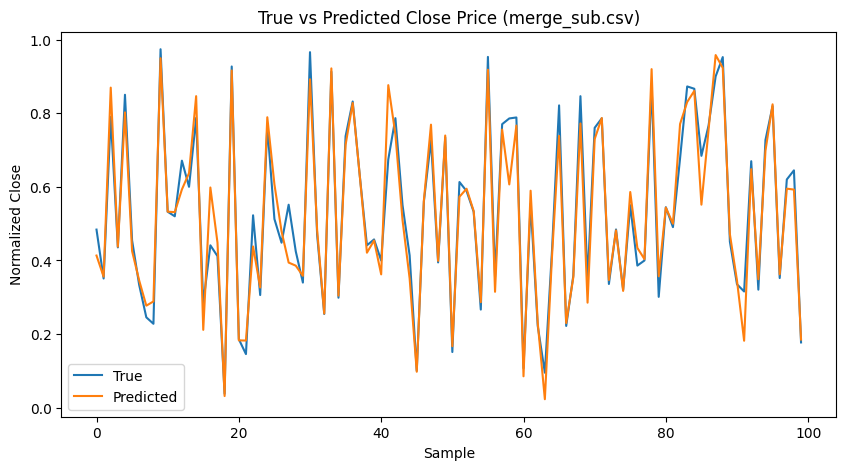

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, Add, BatchNormalization, Dropout, LSTM, MultiHeadAttention, LayerNormalization, Conv1DTranspose
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

df = pd.read_csv("/content/drive/MyDrive/Time series/ohlc2.csv")


df["Volume"] = df["Vol"].str.replace(",", "").astype(float)


df = df.rename(columns={"Symbol": "Ticker"})

SEQ_LEN = 60
FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume']
TARGET = 'Close'


def create_sequences(df, seq_len=60):
    X, y = [], []
    for ticker, group in df.groupby("Ticker"):
        group = group.sort_values("Date")
        values = group[FEATURES].values
        if len(values) <= seq_len:
            continue
        scaler = MinMaxScaler()
        values_scaled = scaler.fit_transform(values)
        for i in range(len(values_scaled) - seq_len):
            X.append(values_scaled[i:i+seq_len])
            y.append(values_scaled[i+seq_len][FEATURES.index(TARGET)])
    return np.array(X), np.array(y).reshape(-1, 1)

X_all, y_all = create_sequences(df, seq_len=SEQ_LEN)

X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

def residual_cnn_block(inputs):
    x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(inputs)
    x = Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(x)
    shortcut = Conv1D(filters=64, kernel_size=1, padding="same")(inputs)
    x = Add()([x, shortcut])
    x = BatchNormalization()(x)
    return x

def transformer_block(inputs, head_size=64, num_heads=4, ff_dim=128, dropout=0.1):
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(inputs, inputs)
    attn = Dropout(dropout)(attn)
    out1 = Add()([attn, inputs])
    out1 = LayerNormalization(epsilon=1e-6)(out1)

    ffn = Dense(ff_dim, activation='relu')(out1)
    ffn = Dense(inputs.shape[-1])(ffn)
    ffn = Dropout(dropout)(ffn)
    out2 = Add()([ffn, out1])
    return LayerNormalization(epsilon=1e-6)(out2)

def build_model(input_shape):
    inputs = Input(shape=input_shape)
    x = residual_cnn_block(inputs)
    x = transformer_block(x)
    x = LSTM(64)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss="mse", metrics=["mae"])
    return model

model = build_model(X_train.shape[1:])
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), verbose=1)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

direction_true = np.sign(y_test[1:] - y_test[:-1])
direction_pred = np.sign(y_pred[1:] - y_pred[:-1])
directional_accuracy = np.mean(direction_true == direction_pred) * 100

print(f"\n--- Evaluation Metrics ---")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Directional Accuracy: {directional_accuracy:.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label="True")
plt.plot(y_pred[:100], label="Predicted")
plt.title("True vs Predicted Close Price (merge_sub.csv)")
plt.xlabel("Sample")
plt.ylabel("Normalized Close")
plt.legend()
plt.show()


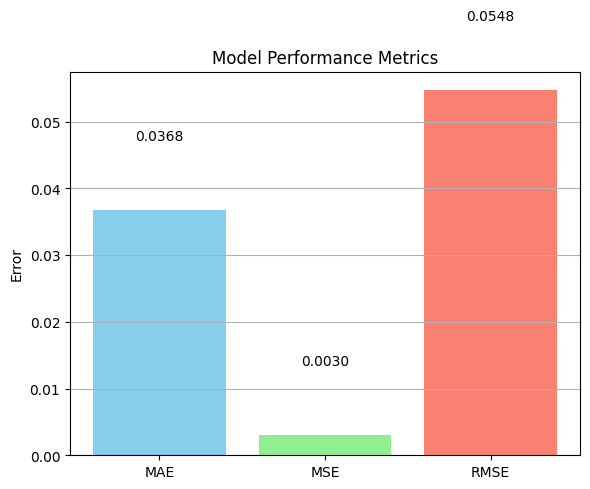

In [ ]:


import seaborn as sns

# -- A. Metric Comparison Bar Chart --
metrics = ['MAE', 'MSE', 'RMSE']
values = [mae, mse, rmse]

plt.figure(figsize=(6, 5))
bars = plt.bar(metrics, values, color=['skyblue', 'lightgreen', 'salmon'])
plt.title("Model Performance Metrics")
plt.ylabel("Error")
plt.grid(axis='y')


for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.4f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


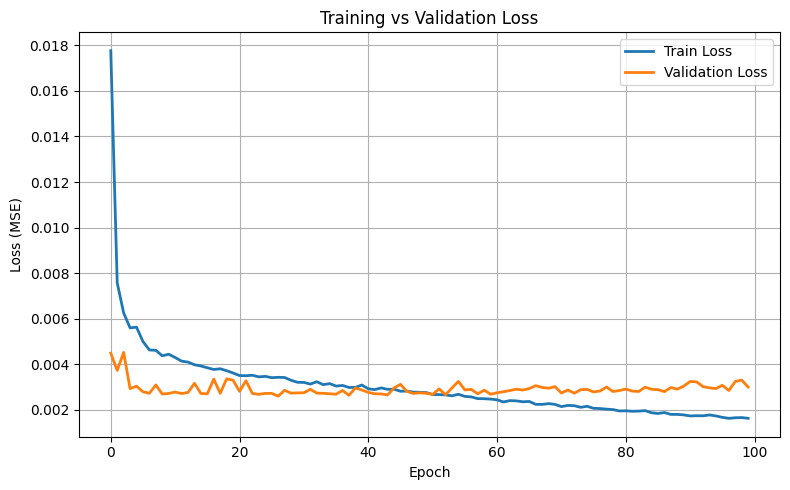

In [ ]:
# -- B. Training vs Validation Loss Curve --
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

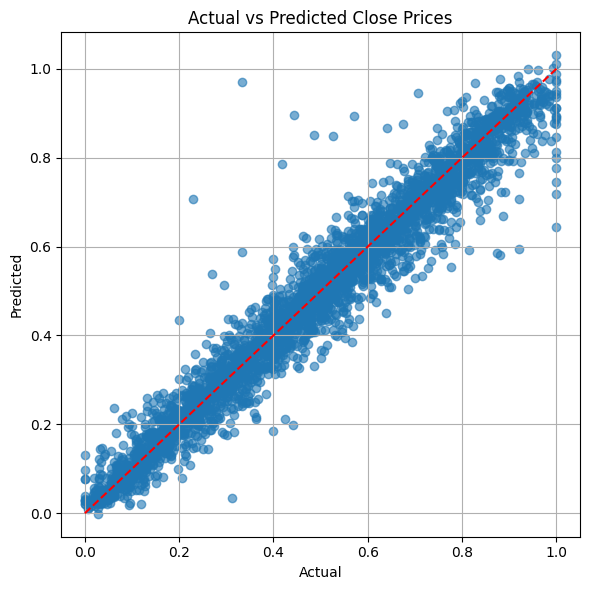

In [ ]:
# -- C. Scatter Plot: Actual vs Predicted --
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Reference line
plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

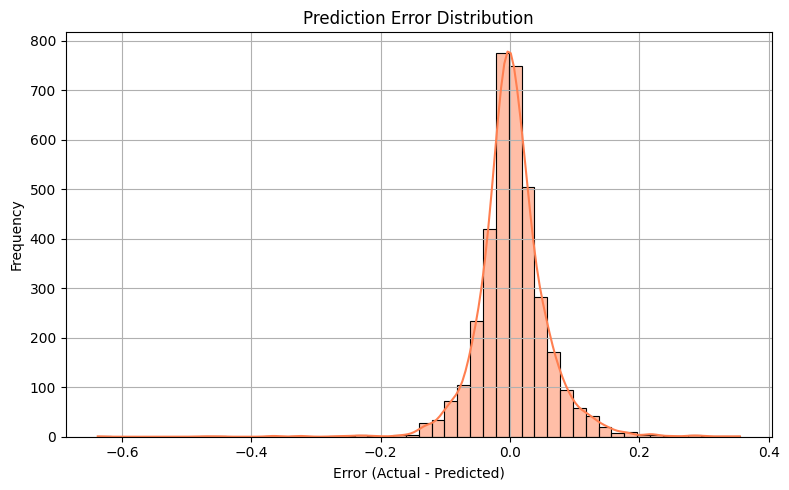

In [ ]:
# -- D. Error Histogram --
errors = y_test.flatten() - y_pred.flatten()
plt.figure(figsize=(8, 5))
sns.histplot(errors, bins=50, kde=True, color='coral')
plt.title("Prediction Error Distribution")
plt.xlabel("Error (Actual - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()